In [300]:
import torch.nn as nn
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split


Load Dataset

In [301]:
transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor()
])

#lung_dataset = datasets.ImageFolder('/home/hampus/dev/bioinformatics/lung_colon_image_set/lung_image_sets',transform=transform)
lung_dataset = datasets.ImageFolder('/home/hampus/dev/bioinformatics/lung_colon_image_set/test',transform=transform)

In [302]:
from pathlib import Path
current_file_directory = Path('cnn.ipynb').resolve().parent

print(current_file_directory)

/home/hampus/dev/bioinformatics


In [303]:
print(lung_dataset.class_to_idx)

{'aca': 0, 'n': 1, 'scc': 2}


Split Dataset to train and val

In [304]:

train_size = int(0.8 * len(lung_dataset)) # 80%
test_val_size = (len(lung_dataset) - train_size)//2 #val and test 10% each
print(test_val_size)

train_dataset, val_dataset, test_dataset = random_split(lung_dataset, [train_size, test_val_size, test_val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

30


In [305]:
print(len(train_loader))
print(len(test_loader))
print(len(val_loader))

#for images in val_loader:
#    pass


images, labels = next(iter(train_loader))
print(images[0].shape)

8
1
1
torch.Size([3, 32, 32])


Define variables

In [306]:
num_classes = 3

Model

In [307]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv_layer_1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.max_pool1 = nn.MaxPool2d(3, 2)
        self.conv_layer2 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3)
        self.conv_layer3 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3)
        self.conv_layer4 = nn.Conv2d(in_channels=8, out_channels=1, kernel_size=3)


        self.fc1 = nn.Linear(64, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        out = self.conv_layer_1(x)
        out = self.max_pool1(out)
        out = self.conv_layer2(out)
        out = self.conv_layer3(out)
        out = self.conv_layer4(out)

        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

model = CNN(num_classes=num_classes)

HyperParameters

In [308]:
num_epochs = 50
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

Train

In [311]:
train_loss = []
val_loss = []

train_accuracy = []
val_accuracy = []

for epoch in range(num_epochs):
    model.train()
    total_train = 0
    correct_train = 0
    for i, (images, labels) in enumerate(train_loader):
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train += len(labels)
        _, pred = torch.max(outputs.data, 1)
        correct_train += (pred == labels).sum().item()
        #for o in outputs:
        #    print(o)

        #print('Loss: {:.4f}'.format(epoch+1, loss.item())) 
        #print(outputs.shape)
        #print(labels)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
    train_loss.append(loss.item())
    train_accuracy.append(correct_train/total_train)


    ##Eval
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in val_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += len(labels)
            correct += (predicted == labels).sum().item()
            loss_v = criterion(outputs, labels)
        val_loss.append(loss_v.item())
        val_accuracy.append(correct/total)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss_v.item():.4f}')
        print("total: ", total)
        print("correct: ", correct)
        print("accuracy: ", correct/total)

Epoch [1/50], Loss: 117350.4531
Epoch [1/50], Loss: 79363.0469
total:  30
correct:  15
accuracy:  0.5
Epoch [2/50], Loss: 97138.1953
Epoch [2/50], Loss: 40260.3242
total:  30
correct:  15
accuracy:  0.5
Epoch [3/50], Loss: 316057.1562
Epoch [3/50], Loss: 249449.8906
total:  30
correct:  7
accuracy:  0.23333333333333334
Epoch [4/50], Loss: 1.0654
Epoch [4/50], Loss: 1.2196
total:  30
correct:  8
accuracy:  0.26666666666666666
Epoch [5/50], Loss: 992312.5000
Epoch [5/50], Loss: 326370.3125
total:  30
correct:  7
accuracy:  0.23333333333333334
Epoch [6/50], Loss: 2005987.2500
Epoch [6/50], Loss: 727261.8125
total:  30
correct:  8
accuracy:  0.26666666666666666
Epoch [7/50], Loss: 4921587.0000
Epoch [7/50], Loss: 553135.1250
total:  30
correct:  15
accuracy:  0.5
Epoch [8/50], Loss: 185946624.0000
Epoch [8/50], Loss: 72653832.0000
total:  30
correct:  8
accuracy:  0.26666666666666666
Epoch [9/50], Loss: 182792816.0000
Epoch [9/50], Loss: 49938192.0000
total:  30
correct:  15
accuracy:  0.5

# Plot Loss and Accuracy

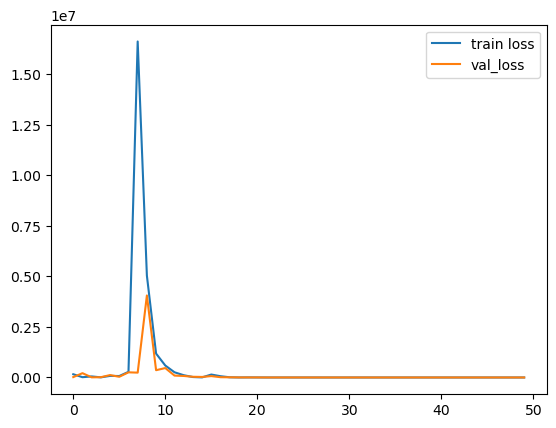

In [288]:
import matplotlib.pyplot as plt
plt.title("loss")
plt.plot(train_loss, label="train loss")
plt.plot(val_loss, label="val_loss")
plt.legend()
plt.show()

In [ ]:
plt.title("Accuracy")
plt.plot(train_accuracy, label="train accuracy")
plt.plot(val_accuracy, label="val accuracy")
plt.legend()
plt.show()

Eval

In [294]:
y_true = []
y_pred = []

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in val_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_true.append(labels)
        y_pred.append(predicted)
        print(labels)
        print(predicted)
        total += len(labels)
        correct += (predicted == labels).sum().item()
    print("total: ", total)
    print("correct: ", correct)
    print("accuracy: ", correct/total)

tensor([0, 2, 1, 2, 2, 1, 1, 2, 0, 0, 1, 2, 0, 1, 0, 0, 0, 2, 1, 0, 0, 2, 1, 1,
        0, 1, 2, 0, 0, 1])
tensor([0, 0, 1, 2, 2, 1, 1, 2, 2, 0, 1, 1, 2, 1, 0, 0, 0, 2, 1, 0, 0, 1, 1, 0,
        2, 1, 2, 0, 2, 1])
total:  30
correct:  22
accuracy:  0.7333333333333333


# Plot confussion matrix

Here we want to make sure that we do not get any false negatives, only false positives.

0: aca - adenocarcinoma (cancer) \
1: n - benign tissue (non-cancerous) \
2: scc - squamous cell carcinoma (cancer)

[tensor([0, 2, 1, 2, 2, 1, 1, 2, 0, 0, 1, 2, 0, 1, 0, 0, 0, 2, 1, 0, 0, 2, 1, 1,
        0, 1, 2, 0, 0, 1])]
[tensor([0, 0, 1, 2, 2, 1, 1, 2, 2, 0, 1, 1, 2, 1, 0, 0, 0, 2, 1, 0, 0, 1, 1, 0,
        2, 1, 2, 0, 2, 1])]
{'aca': 0, 'n': 1, 'scc': 2}


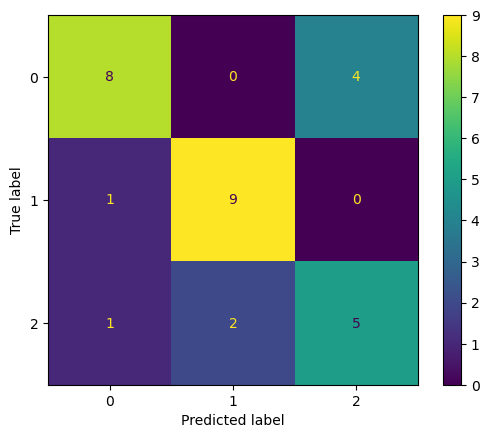

In [298]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
print(y_true)
print(y_pred)
cm = confusion_matrix(y_true[0], y_pred[0])
ConfusionMatrixDisplay(cm).plot()

print(lung_dataset.class_to_idx)